# Inference of MicroRNA-Messenger RNA Interactions in TCGA-BRCA
TCGA: The Cancer Genome Atlas  
BRCA: Breast Invasive Carcinoma

# Importing Libraries and Configurations

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy import stats

# Add project root to Python's path
sys.path.append(os.path.abspath(os.path.join('..', '..')))

from config import (
    AGGREGATED_READS_FILES,
    BRCA_INTERIM_FILES_DIRS,
    BRCA_PROCESSED_FILES_DIRS,
    BRCA_PROCESSED_FILES_PATHS,
    MIRWALK_MIR_MAPPING_FILE_PATH,
    MIRWALK_PROCESSED_DATA_DIR,
    SPEARMAN_ANALYSIS_PARAMETERS,
)

# Function

In [2]:
def preparing_data_for_spearman(processed_dir_path):
    """
    Prepare normalized expression data of a cohort for Spearman correlation analysis.

    Parameters
    ----------
    processed_dir_path : str
        Path to the directory containing processed expression data files.

    Returns
    -------
    dict of pd.DataFrame
        A dictionary with keys:
        - 'mir' : DataFrame with aggregated microRNA read counts.
        - 'rna' : DataFrame with aggregated messenger RNA read counts.
        Both DataFrames have case IDs as indices and molecule identifiers as columns.
    """
    # Create a DataFrame for the files metadata
    df_files_metadata = pd.read_csv(BRCA_PROCESSED_FILES_PATHS['files'])

    # Initialize a dictionary for the prepared DataFrames
    aggregated_norm_reads = dict()

    # Prepare the aggregated normalized reads files
    for experimental_strategy in ['mir', 'rna']:
        # Define the experimental strategy related parameters
        drop_column = ['is_expressed']
        if experimental_strategy == 'mir':
            file_name = AGGREGATED_READS_FILES['mir-norm']
            index_column = 'accession_id'
        else:
            file_name = AGGREGATED_READS_FILES['rna-norm']
            index_column = 'gene_name'
            drop_column = drop_column + ['gene_id']
        
        # Get the expressed molecules and set the primary key as index
        file_path = os.path.join(processed_dir_path, file_name)
        df_aggregated_norm_reads = pd.read_csv(file_path) \
            .query('is_expressed == 1') \
            .drop(columns=drop_column) \
            .set_index(keys=index_column)
        
        # Map the file ID to the associated case ID
        related_files = list(df_aggregated_norm_reads.columns)
        df_files_mapping = pd.DataFrame(related_files, columns=['file_id'])
        df_files_mapping = df_files_mapping \
            .merge(
                right=df_files_metadata,
                left_on='file_id',
                right_on='file_id',
                how='left',
            ) \
            [['file_id', 'case_id']]
        
        # Transpose the DataFrame and set the case ID as index
        df_aggregated_norm_reads = df_aggregated_norm_reads \
            .transpose() \
            .reset_index() \
            .rename(columns={'index': 'file_id'}) \
            .merge(
                right=df_files_mapping,
                left_on='file_id',
                right_on='file_id',
                how='inner',
            ) \
            .drop(columns=['file_id']) \
            .set_index(keys='case_id') \
            .sort_index(ascending=True)
        
        # Store the prepared DataFrame in the dictionary
        aggregated_norm_reads[experimental_strategy] = \
            df_aggregated_norm_reads.copy()
    
    return aggregated_norm_reads

In [3]:
def computing_single_pair_spearman(df_mir_expression, df_rna_expression):
    """
    Calculate the Spearman correlation coefficient between the expression profile 
    of a single microRNA and messenger RNA pair.
    
    Parameters
    ----------
    df_mir_expression : pd.Series
        Expression values of a single microRNA across samples.
    df_rna_expression : pd.Series
        Expression values of a single messenger RNA across the same samples.

    Returns
    -------
    dict
        A dictionary containing:
        - 'accession_id': microRNA accession ID.
        - 'gene_name': gene name of the messenger RNA.
        - 'spearman_coefficient': Spearman correlation coefficient.
        - 'p_value': p-value for the hypothesis test that correlation < 0.
    """
    # Calculate the Spearman correlation coefficient for the pair
    statistic, pvalue = stats.spearmanr(
        a=df_mir_expression, # Samples of the expressed microRNA
        b=df_rna_expression, # Samples of the expressed messenger RNAs
        axis=0, # Each row is a observation, while the columns are variables
        nan_policy='propagate', # Return NaN when input contains it
        alternative='less', # The correlation is negative in miRNA-mRNA interactions
    )
    
    # Create a dictionary to represent the result
    result = {
        'accession_id': df_mir_expression.name,
        'gene_name': df_rna_expression.name,
        'spearman_coefficient': statistic,
        'p_value': pvalue,
    }
    
    return result

In [4]:
def computing_parallel_spearman(cohort):
    """
    Calculate Spearman correlation coefficients between all pairs of expressed microRNAs and 
    messenger RNAs for a given cohort using parallel processing.

    Parameter
    ---------
    cohort : str
        Name of the cohort used to locate interim and processed data directories.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the Spearman correlation results with one row per microRNA-
        messenger RNA pair and their corresponding correlation values.
    """
    # Define the cohort interim and processed directories path
    dir_base_name = (cohort.lower()).replace(' ', '-')
    interim_dir_path = BRCA_INTERIM_FILES_DIRS[dir_base_name]
    processed_dir_path = BRCA_PROCESSED_FILES_DIRS[dir_base_name]
    
    # Prepare the expression data of the expressed molecules
    aggregated_norm_reads = preparing_data_for_spearman(processed_dir_path)
    df_mir_expression = aggregated_norm_reads['mir']
    df_rna_expression = aggregated_norm_reads['rna']
    
    # Get the sets of expressed microRNAs and messenger RNAs
    expressed_mirs = list(df_mir_expression.columns)
    expressed_rnas = list(df_rna_expression.columns)
    
    # Compute in parallel the Spearman correlation coefficient for each pair
    spearman_results = Parallel(n_jobs=-1, prefer='processes')(
        delayed(computing_single_pair_spearman)
        (df_mir_expression[mir], df_rna_expression[rna])
        for mir in expressed_mirs
        for rna in expressed_rnas
    )
    
    # Create a DataFrame for the computing results
    df_spearman_results = pd.DataFrame(spearman_results)
    
    # Store the DataFrame of Spearman correlation analysis
    df_spearman_results.to_csv(
        os.path.join(interim_dir_path, SPEARMAN_ANALYSIS_PARAMETERS['file']),
        index=False
    )
    
    return df_spearman_results

# Anticorrelation Analysis of Interactions

## Basal-like

In [5]:
# Compute the Spearman correlation coefficients for Basal-like tumor tissue
df_spearman_results = computing_parallel_spearman('Basal-like')

In [6]:
# Print the DataFrame of Spearman results for this cohort
df_spearman_results

,accession_id,gene_name,spearman_coefficient,p_value
0,MIMAT0000062,TSPAN6,-0.099821,0.178811
1,MIMAT0000062,DPM1,0.066141,0.728626
2,MIMAT0000062,SCYL3,0.176059,0.948574
3,MIMAT0000062,C1orf112,-0.026828,0.402586
4,MIMAT0000062,FGR,-0.114274,0.145960
...,...,...,...,...
3569745,MIMAT0026480,AC055839.2,0.209047,0.974003
3569746,MIMAT0026480,NOTCH2NLC,0.138569,0.899723
3569747,MIMAT0026480,AP003071.5,0.066159,0.728682
3569748,MIMAT0026480,DUS4L-BCAP29,0.158554,0.928785


## HER2-enriched

In [ ]:
# Compute the Spearman correlation coefficients for HER2-enriched tumor tissue
df_spearman_results = computing_parallel_spearman('HER2-enriched')

In [ ]:
# Print the DataFrame of Spearman results for this cohort
df_spearman_results

## Luminal A

In [ ]:
# Compute the Spearman correlation coefficients for Luminal A tumor tissue
df_spearman_results = computing_parallel_spearman('Luminal A')

In [ ]:
# Print the DataFrame of Spearman results for this cohort
df_spearman_results

## Luminal B

In [ ]:
# Compute the Spearman correlation coefficients for Luminal B tumor tissue
df_spearman_results = computing_parallel_spearman('Luminal B')

In [ ]:
# Print the DataFrame of Spearman results for this cohort
df_spearman_results

## Paired Normal

In [ ]:
# Compute the Spearman correlation coefficients for Paired Normal tissue
df_spearman_results = computing_parallel_spearman('Paired Normal')

In [ ]:
# Print the DataFrame of Spearman results for this cohort
df_spearman_results

# Interactions of Interest from miRWalk

In [7]:
# Initialize a DataFrame for the interactions of interest from miRWalk
df_mirwalk_interactions = pd.DataFrame(columns=['mirna_name', 'gene_name'])

# List the interaction files downloaded from miRWalk
files = [f for f in os.listdir(MIRWALK_PROCESSED_DATA_DIR) if f.startswith('MIMAT')]

# Iterate over each interactions file from miRWalk
for file in files:
    # Create a DataFrame for the interactions of interest of this microRNA
    file_path = os.path.join(MIRWALK_PROCESSED_DATA_DIR, file)    
    df_mir_interactions = pd.read_csv(file_path, low_memory=False) \
        .query('is_interaction_of_interest == 1') \
        [['mirna_name', 'gene_name']] \
        .drop_duplicates()
    
    # Concatenate the interactions of interest to the others
    df_mirwalk_interactions = pd.concat(
        [df_mirwalk_interactions, df_mir_interactions], ignore_index=True
    )

# Add the microRNA accession IDs to the DataFrame
df_mir_mapping = pd.read_csv(MIRWALK_MIR_MAPPING_FILE_PATH)
df_mirwalk_interactions = df_mir_mapping \
    .merge(
        right=df_mirwalk_interactions,
        left_on='mirna_name',
        right_on='mirna_name',
        how='inner',
    )

In [8]:
# Print the DataFrame of interactions of interest from miRWalk
df_mirwalk_interactions

,accession_id,mirna_name,gene_name
0,MIMAT0003322,hsa-miR-652-3p,KCNN3
1,MIMAT0003322,hsa-miR-652-3p,HSD3B7
2,MIMAT0003322,hsa-miR-652-3p,UBE2I
3,MIMAT0003322,hsa-miR-652-3p,SLC35C2
4,MIMAT0003322,hsa-miR-652-3p,GGCX
...,...,...,...
51125,MIMAT0000736,hsa-miR-381-3p,SLC6A17
51126,MIMAT0000736,hsa-miR-381-3p,XKR7
51127,MIMAT0000736,hsa-miR-381-3p,RFFL
51128,MIMAT0000736,hsa-miR-381-3p,DNAJB14


# Interaction Inference
According to Anticorrelation Analysis [`statistic`] and miRWalk Data [`biology`]

In [10]:
df_basal_like_pairs = df_spearman_results \
    .merge(
        right=df_mirwalk_interactions,
        left_on=['accession_id', 'gene_name'],
        right_on=['accession_id', 'gene_name'],
        how='inner',
    ) \
    .query('(p_value < 0.05) and (spearman_coefficient < -0.3)') \
    .reset_index(drop=True) \
    [[
        'accession_id',
        'mirna_name',
        'gene_name',
        'spearman_coefficient',
        'p_value',
    ]]
    
df_basal_like_pairs

,accession_id,mirna_name,gene_name,spearman_coefficient,p_value
0,MIMAT0000062,hsa-let-7a-5p,CCNJL,-0.312514,0.001605
1,MIMAT0000064,hsa-let-7c-5p,ADIPOR2,-0.325673,0.001042
2,MIMAT0000064,hsa-let-7c-5p,E2F2,-0.354196,0.000382
3,MIMAT0000064,hsa-let-7c-5p,BZW1,-0.304257,0.002084
4,MIMAT0000064,hsa-let-7c-5p,JOSD1,-0.330921,0.000872
...,...,...,...,...,...
1116,MIMAT0022834,hsa-miR-365b-3p,IKZF4,-0.306882,0.001919
1117,MIMAT0022834,hsa-miR-365b-3p,GXYLT1,-0.312495,0.001605
1118,MIMAT0022834,hsa-miR-365b-3p,MGAT5,-0.325545,0.001046
1119,MIMAT0022834,hsa-miR-365b-3p,IFNLR1,-0.304422,0.002073


# Network Draft

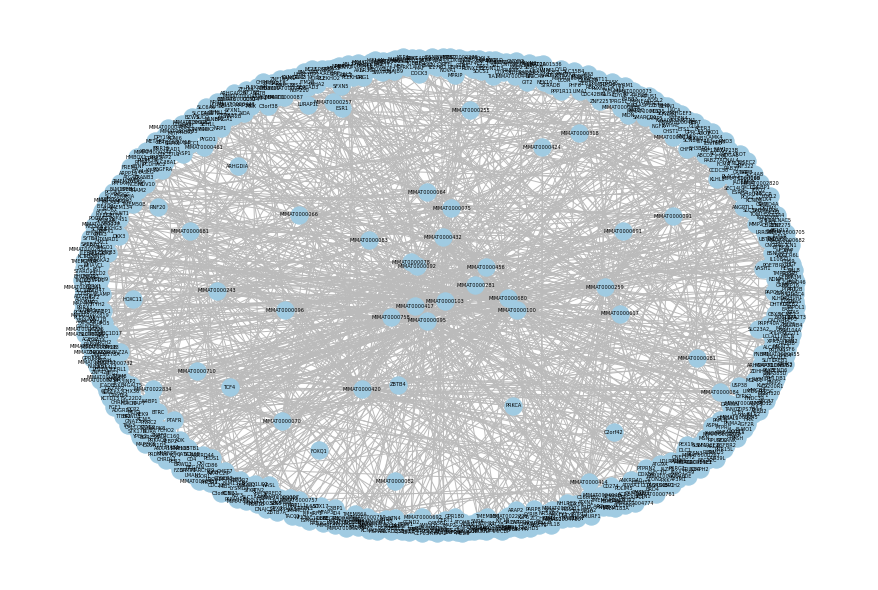

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# G = nx.Graph()
G = nx.from_pandas_edgelist(
    df=df_basal_like_pairs,
    source='accession_id',
    target='gene_name',
)

# nx.draw(G, with_labels=False)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=100)
nx.draw(G, pos,
        with_labels=True, 
        node_color='#A0CBE2', 
        edge_color='#BBBBBB',
        font_size=5,
        font_color='black')

plt.show()